# Introduction to Transfer Learning
This notebook is part of the [SachsLab Workshop for Intracranial Neurophysiology and Deep Learning](https://github.com/SachsLab/IntracranialNeurophysDL).

### Lesson Reference
To supplement the presented material, consult the tutorial here: https://www.tensorflow.org/beta/tutorials/images/transfer_learning
* Freeze most layers, update only certain layer(s), then unfreeze all and update

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/03_04_CNN_transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/03_04_CNN_transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

### Normalize Environments
Run the first two cells to normalize Local / Colab environments, then proceed below for the lesson.

In [1]:
from pathlib import Path
import os
try:
    # See if we are running on google.colab
    import google.colab
    from google.colab import files
    os.chdir('..')
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        !pip install -q kaggle
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
    IN_COLAB = True
    # Setup tensorflow 2.0
    !pip install -q tensorflow-gpu==2.0.0-beta0
except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

In [2]:
# Additional imports
import tensorflow as tf
import datetime
import numpy as np
import matplotlib.pyplot as plt
from indl import turbo_cmap, reset_keras

# %load_ext tensorboard
plt.rcParams.update({'font.size': 22})
%load_ext autoreload
%autoreload 2

In [3]:
# Download and unzip data
datadir = Path.cwd() / 'data' / 'kjm_ecog'
if not (datadir / 'converted').is_dir():
    !kaggle datasets download --unzip --path {str(datadir / 'converted' / 'faces_basic')} cboulay/kjm-ecog-faces-basic
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")

Data directory found. Skipping download.


## Strategy

The model comprises a block for temporal filters, a block for a spatial filter, a block for further convolutional layers, and a block for the classifier. The spatial filter is going to be unique to each recording, but the other blocks could be shared across recordings.

If we start with a well-performing model for one recording then whenever we switch to a new recording the different sensor locations are going to be a poor fit and create large errors. We don't want those errors to propagate through and update weights in the entire model. For each new recording, we freeze the layers that are shared so they don't update, and we allow only the spatial filter to update. After the spatial filter has updated, we can then unfreeze all layers to perform fine tuning at a lower learning rate.

### Get basic info about each recording

We need to know the data shape for each recording.
We are also goign to take this opportunity to pre-determine the training/validation sets for each recording.

In [4]:
participant_names = ['aa', 'ap', 'ca', 'de', 'fp', 'ha', 'ja',
                     'jm', 'jt', 'mv', 'rn', 'rr', 'wc', 'zt']
test_participant = 'ca'  # To validate the transfer-learning model vs a naive model.
train_participants = [_ for _ in participant_names if _ != test_participant]

In [5]:
from data.utils.fileio import load_faces_houses
from collections import OrderedDict
from sklearn.model_selection import StratifiedShuffleSplit

P_TRAIN = 0.8

rec_infos = OrderedDict()
for p_name in participant_names:
    X, Y, ax_info = load_faces_houses(datadir, p_name, feature_set='full')
    n_trials = len(ax_info['instance_data'])
    sss = StratifiedShuffleSplit(n_splits=1, train_size=P_TRAIN, random_state=0)
    trn, tst = next(sss.split(X, Y))
    rec_infos[p_name] = {
        'n_trials': n_trials,
        'n_timestamps': len(ax_info['timestamps']),
        'fs': ax_info['fs'],
        'n_channels': len(ax_info['channel_names']),
        'trn': trn,
        'tst': tst
    }
    
print([(p_name, info['n_channels']) for p_name, info in rec_infos.items()])

[('aa', 46), ('ap', 41), ('ca', 50), ('de', 31), ('fp', 52), ('ha', 39), ('ja', 60), ('jm', 56), ('jt', 102), ('mv', 58), ('rn', 42), ('rr', 40), ('wc', 39), ('zt', 58)]


### Define the model in parts

In [6]:
# EEGNet-like model with a pair of parallel input layers.
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import layers

def make_models(T, aug_offset=100, n_classes=3,
                n_temporal_short=8, len_temporal_short=28,
                n_temporal_long=4, len_temporal_long=220,
                D=2,
                activation='relu',
                downsamp_1=8,
                n_pointwise_filters=25,
                len_kernel_2=47, downsamp_2=5,
                norm_rate=0.45, dropout_rate=0.45, l1_reg=0.01, l2_reg=0.01,
                rec_infos={}):

    # Shared head block:
    # Temporal kernel convolutions.
    head_input = tf.keras.Input(shape=(T - aug_offset, None, 1))
    _y_short = layers.Conv2D(n_temporal_short, (len_temporal_short, 1),
                             padding='same', use_bias=False)(head_input)
    _y_long = layers.Conv2D(n_temporal_long, (len_temporal_long, 1),
                            padding='same', use_bias=False)(head_input)
    _y_head = layers.Concatenate(axis=-1)([_y_short, _y_long])
    _y_head = layers.BatchNormalization(axis=1)(_y_head)
    shared_head = tf.keras.Model(inputs=head_input, outputs=_y_head, name='shared_head')
    shared_head.summary()
    shared_head.save(datadir / 'models' / 'shared_head_naive.h5')
    
    # Skip over the spatial filter for now
    
    # Shared tail block: Feature aggregation and classification
    tail_input = tf.keras.Input(shape=(T - aug_offset, 1, (n_temporal_short + n_temporal_long) * D))
    tail_y = layers.AveragePooling2D((downsamp_1, 1))(tail_input)
    tail_y = layers.Dropout(dropout_rate)(tail_y)
    tail_y = layers.SeparableConv2D(n_pointwise_filters, (len_kernel_2, 1), padding='valid', use_bias=False)(tail_y)
    tail_y = layers.Activation(activation)(tail_y)
    tail_y = layers.BatchNormalization(axis=1)(tail_y)
    tail_y = layers.AveragePooling2D((downsamp_2, 1))(tail_y)
    tail_y = layers.Dropout(dropout_rate)(tail_y)
    tail_y = layers.Flatten()(tail_y)
    tail_y = layers.Dense(n_classes, kernel_constraint=max_norm(norm_rate))(tail_y)
    tail_y = layers.Activation('softmax')(tail_y)
    shared_tail = tf.keras.Model(inputs=tail_input, outputs=tail_y, name='shared_tail')
    shared_tail.summary()
    shared_tail.save(datadir / 'models' / 'shared_tail_naive.h5')
    
    # Now we create unique spatial filter model parts for each participant
    ss_layers = OrderedDict()
    for ss_name, ss_info in rec_infos.items():
        ss_layers[ss_name] = [
            layers.DepthwiseConv2D((1, ss_info['n_channels']), use_bias=False,
                                   depth_multiplier=D,
                                   kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
                                   depthwise_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
                                   depthwise_constraint=max_norm(1.)),
            layers.Activation(activation),
            layers.BatchNormalization(axis=1)
        ]
            
    return shared_head, shared_tail, ss_layers

In [7]:
MAX_OFFSET = 100
T = rec_infos[test_participant]['n_timestamps']  # All recordings should have same timestamps.

shared_head, shared_tail, ss_layers = make_models(
    T, n_classes=len(np.unique(Y)), aug_offset=MAX_OFFSET, rec_infos=rec_infos)

Model: "shared_head"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 701, None, 1 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 701, None, 8) 224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 701, None, 4) 880         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 701, None, 12 0           conv2d[0][0]                     
                                                                 conv2d_1[0][0]         

In [8]:
reset_keras(shared_head)
reset_keras(shared_tail)

7
184


#### Prepare Data

In [9]:
def get_ds_train_valid(X, Y, trn, tst, batch_size=5, max_offset=0):
    # Convert Y from strings to integers.
    classes, y = np.unique(Y, return_inverse=True)
    n_trials = len(y)
    n_subsamps = X.shape[1] - max_offset
    
    def augmentation_fn(x_dat, y_dat):
        # Randomly select an integer between 0 and max_offset
        t_offset = tf.random.uniform(shape=[], minval=0, maxval=max_offset, dtype=tf.int32)
        # Slice the data to keep samples from t_offset to t_offset + n_subsamps
        # tf.slice syntax arguments are: data, slice starts (per dim), slice length (per dim)
        # Though -1 as a length is special, and means to take all.
        x_dat = tf.slice(x_dat, [t_offset, 0, 0], [n_subsamps, -1, -1])
        return x_dat, y_dat
    
    def augmentation_valid_fn(x_dat, y_dat):
        # For validation data, take only the last n_subsamps
        x_dat = tf.slice(x_dat, [max_offset, 0, 0], [n_subsamps, -1, -1])
        return x_dat, y_dat
    
    def preprocess_fn(x_dat, y_dat):
        # Data are by default 64-bit. GPUs work better with 32-bit (or even 16-bit, depending)
        x_dat = tf.cast(x_dat, tf.float32)
        # keras Conv layers expect a 'colour depth' dimension.
        x_dat = tf.expand_dims(x_dat, -1)
        y_dat = tf.cast(y_dat, tf.uint8)
        return x_dat, y_dat
    
    # Separate input data into training and validation sets.
    X_train, X_valid, y_train, y_valid = X[trn], X[tst], y[trn], y[tst]
    n_train = len(y_train)
    ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    ds_valid = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
    
    # Prepare (queue?) functions to be run on the data.
    ds_train = ds_train.map(preprocess_fn)
    ds_valid = ds_valid.map(preprocess_fn)
    if max_offset > 0:
        ds_train = ds_train.map(augmentation_fn)
        ds_valid = ds_valid.map(augmentation_valid_fn)
    ds_train = ds_train.shuffle(n_train + 1).batch(batch_size, drop_remainder=True)
    ds_valid = ds_valid.batch(batch_size)
    
    return ds_train, ds_valid, n_train

### Warm Start: Training a model normally with one recording

In [10]:
BATCH_SIZE = 10
N_EPOCHS = 50
p_name = participant_names[-1]

In [11]:
X, Y, ax_info = load_faces_houses(datadir, p_name, feature_set='full')

ds_train, ds_valid, n_train = get_ds_train_valid(X, Y,
                                                 rec_infos[p_name]['trn'],
                                                 rec_infos[p_name]['tst'],
                                                 batch_size=BATCH_SIZE,
                                                 max_offset=MAX_OFFSET)

xfer_model = tf.keras.Sequential([
    tf.keras.models.load_model(datadir / 'models' / 'shared_head_naive.h5'),
    *ss_layers[p_name],
    tf.keras.models.load_model(datadir / 'models' / 'shared_tail_naive.h5')
], name='xfer_full')
xfer_model.compile(loss='sparse_categorical_crossentropy',
                   optimizer='Nadam', metrics=['accuracy'])
xfer_model.summary()

history = xfer_model.fit(x=ds_train, epochs=N_EPOCHS, validation_data=ds_valid, verbose=1)

xfer_model.layers[0].save(datadir / 'models' / 'shared_head.h5')
xfer_model.layers[-1].save(datadir / 'models' / 'shared_tail.h5')

W0906 03:27:13.183911 140173290616640 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 03:27:13.259059 140173290616640 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Model: "xfer_full"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
shared_head (Model)          (None, 701, None, 12)     3908      
_________________________________________________________________
depthwise_conv2d_13 (Depthwi (None, 701, None, 24)     1392      
_________________________________________________________________
activation_15 (Activation)   (None, 701, None, 24)     0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 701, None, 24)     2804      
_________________________________________________________________
shared_tail (Model)          (None, 3)                 2495      
Total params: 10,599
Trainable params: 7,713
Non-trainable params: 2,886
_________________________________________________________________
Epoch 1/50
48/48 [==============================] - 3s 62ms/step - loss: 1.4380 - accuracy: 0.6042 - val_loss: 0.000

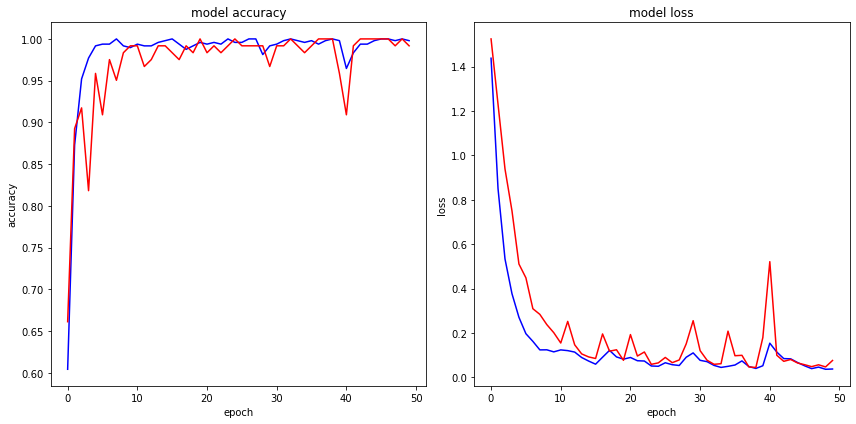

In [12]:
fig = plt.figure(figsize=(12, 6), facecolor='white')
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()

plt.show()

### Train model for each recording with freezing then fine-tuning

In [13]:
BATCH_SIZE = 10
N_EPOCHS_SF = 40
N_EPOCHS_FINETUNE = 60
N_ITERS_ACROSS_SESS = 5
LR_SPAT_FILT = 0.0003
LR_FINE_TUNE = LR_SPAT_FILT / 10

In [14]:
hists = {}
for ep_ix in range(N_ITERS_ACROSS_SESS):
    for p_ix, p_idx in enumerate(np.random.permutation(len(train_participants))):
        
        p_name = train_participants[p_idx]
        rec_info = rec_infos[p_name]
        
        # Load data for this session
        X, Y, ax_info = load_faces_houses(datadir, p_name, feature_set='full')
        
        # Prepare the data for DL
        ds_train, ds_valid, n_train = get_ds_train_valid(X, Y,
                                                         rec_info['trn'],
                                                         rec_info['tst'],
                                                         batch_size=BATCH_SIZE,
                                                         max_offset=MAX_OFFSET)
        
        # Build the model for this session by combining shared layers
        # and individual layer. Each sub-model should keep its weights
        # from previous training.
        _model = tf.keras.Sequential([
            tf.keras.models.load_model(datadir / 'models' / 'shared_head.h5'),
            *ss_layers[p_name],
            tf.keras.models.load_model(datadir / 'models' / 'shared_tail.h5')
        ], name=p_name + '_full')
        
        # Freeze layers and compile with correct optimizer lr.
        _model.layers[0].trainable = False
        _model.layers[-1].trainable = False
        optimizer = tf.keras.optimizers.RMSprop(lr=LR_SPAT_FILT)
        _model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=optimizer, metrics=['accuracy'])
        
        if ep_ix == 0 and p_ix == 0:
            _model.summary()
            
        # Train model
        print("Training model {} ({} of {})".format(_model.name, ep_ix + 1,
                                                    N_ITERS_ACROSS_SESS))
        hist_1 = _model.fit(x=ds_train,
                            epochs=N_EPOCHS_SF,
                            validation_data=ds_valid,
                            verbose=0)
        print("Ending acc and val acc: {:.3f}, {:.3f}".format(
            hist_1.history['accuracy'][-1], hist_1.history['val_accuracy'][-1]))
        
        # Fine-tune model
        # Unfreeze layers and compile.
        _model.layers[0].trainable = True
        _model.layers[-1].trainable = True
        optimizer = tf.keras.optimizers.RMSprop(lr=LR_FINE_TUNE)
        _model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=optimizer, metrics=['accuracy'])
        
        if ep_ix == 0 and p_ix == 0:
            _model.summary()
        
        print("Fine-tuning model {} ({} of {})".format(_model.name, ep_ix + 1,
                                                       N_ITERS_ACROSS_SESS))
        hist_2 = _model.fit(x=ds_train,
                            epochs=N_EPOCHS_FINETUNE,
                            validation_data=ds_valid,
                            verbose=0)
        print("Ending acc and val acc: {:.3f}, {:.3f}".format(
            hist_2.history['accuracy'][-1], hist_2.history['val_accuracy'][-1]))
        
        if p_name not in hists:
            hists[p_name] = []
        hists[p_name].append(hist_1.history)
        hists[p_name].append(hist_2.history)
        
        _model.layers[0].save(datadir / 'models' / 'shared_head.h5')
        _model.layers[-1].save(datadir / 'models' / 'shared_tail.h5')

W0906 03:27:50.394626 140173290616640 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0906 03:27:50.469765 140173290616640 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Model: "mv_full"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
shared_head (Model)          (None, 701, None, 12)     3908      
_________________________________________________________________
depthwise_conv2d_9 (Depthwis (None, 701, None, 24)     1392      
_________________________________________________________________
activation_11 (Activation)   (None, 701, None, 24)     0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 701, None, 24)     2804      
_________________________________________________________________
shared_tail (Model)          (None, 3)                 2495      
Total params: 10,599
Trainable params: 2,794
Non-trainable params: 7,805
_________________________________________________________________
Training model mv_full (1 of 5)
Ending acc and val acc: 0.981, 0.926
Model: "mv_full"
________________________________

AttributeError: 'Activation' object has no attribute 'save'

In [ ]:
def plt_hist(key):
    # Uses data from outer scope
    sess_breaks = np.arange(N_ITERS_ACROSS_SESS) * (N_EPOCHS_SF + N_EPOCHS_FINETUNE)
    finetune_breaks = sess_breaks + N_EPOCHS_SF
    
    for p_name in train_participants:
        dat = np.hstack([_[key] for _ in hists[p_name]])
        plt.plot(dat, label=p_name)
    
    for xx in sess_breaks:
        plt.axvline(xx, color='k', alpha=0.5)
    for xx in finetune_breaks:
        plt.axvline(xx, color='r', alpha=0.5)
        
    plt.xlabel('epoch')

fig = plt.figure(figsize=(12, 12), facecolor='white')
plt.subplot(2, 2, 1)
plt_hist('accuracy')
plt.ylabel('accuracy')
plt.title('Training')
plt.legend(loc='lower right')

plt.subplot(2, 2, 2)
plt_hist('val_accuracy')
plt.title('Validation')

plt.subplot(2, 2, 3)
plt_hist('loss')
plt.ylabel('loss')

plt.subplot(2, 2, 4)
plt_hist('val_loss')

plt.tight_layout()
plt.show()

Classification accuracy on the validation set seems to improve as the shared models are updated with each recording.

Validation loss improves for many but not all data sets.

## Transfer the model to unseen data

A single 'test participant' was not included in the above training. Let's see how well we can classify data from this participant using a model that is pre-initialized with weights learned from other subjects and a naive model with random initial weights.

In [ ]:
# First clear all models from memory.
reset_keras(shared_head)
reset_keras(shared_tail)

naive_model = tf.keras.Sequential([
    tf.keras.models.load_model(datadir / 'models' / 'shared_head_naive.h5'),
    *ss_layers[test_participant],
    tf.keras.models.load_model(datadir / 'models' / 'shared_tail_naive.h5')
], name=test_participant + '_naive')
naive_model.compile(loss='sparse_categorical_crossentropy',
                   optimizer='Nadam', metrics=['accuracy'])

# Backup the naive weights for the whole model
naive_model.save_weights(str(datadir / 'models' / (test_participant + '_full_naive.h5')))
    
# Get the transfer model.
xfer_model = tf.keras.Sequential([
    tf.keras.models.load_model(datadir / 'models' / 'shared_head.h5'),
    *ss_layers[test_participant],
    tf.keras.models.load_model(datadir / 'models' / 'shared_tail.h5')
], name='xfer_full')
xfer_model.compile(loss='sparse_categorical_crossentropy',
                   optimizer='Nadam', metrics=['accuracy'])

In [ ]:
N_EPOCHS = 200
N_EPOCHS_SF = 20
shared_layers = [0, 2]

rec_info = rec_infos[test_participant]

# Load data for this session
X, Y, ax_info = load_faces_houses(datadir, test_participant, feature_set='full')

# Prepare the data for DL
ds_train, ds_valid, n_train = get_ds_train_valid(X, Y,
                                                 rec_info['trn'],
                                                 rec_info['tst'],
                                                 batch_size=BATCH_SIZE,
                                                 max_offset=MAX_OFFSET)

# Train model
print("Training xfer model {} spatial filter".format(xfer_model.name))
for layer_ix in shared_layers:
    xfer_model.layers[layer_ix].trainable = False
xfer_model.compile(loss='sparse_categorical_crossentropy',
                   optimizer='Nadam', metrics=['accuracy'])
hist_xfer_sf = xfer_model.fit(x=ds_train,
                              epochs=N_EPOCHS_SF,
                              validation_data=ds_valid,
                              verbose=1)

print("Training xfer model {} entirity".format(xfer_model.name))
for layer_ix in shared_layers:
    xfer_model.layers[layer_ix].trainable = True
xfer_model.compile(loss='sparse_categorical_crossentropy',
                   optimizer='Nadam', metrics=['accuracy'])
hist_xfer_all = xfer_model.fit(x=ds_train,
                               epochs=N_EPOCHS - N_EPOCHS_SF,
                               validation_data=ds_valid,
                               verbose=1)
print("Ending acc and val acc: {:.3f}, {:.3f}".format(
    hist_xfer_all.history['accuracy'][-1], hist_xfer_all.history['val_accuracy'][-1]))

# Train naive model
print("Training naive model {}".format(naive_model.name))
naive_model.load_weights(str(datadir / 'models' / (test_participant + '_full_naive.h5')))
naive_model.compile(loss='sparse_categorical_crossentropy',
                    optimizer='Nadam', metrics=['accuracy'])
hist_naive = naive_model.fit(x=ds_train,
                             epochs=N_EPOCHS,
                             validation_data=ds_valid,
                             verbose=1)
print("Ending acc and val acc: {:.3f}, {:.3f}".format(
    hist_naive.history['accuracy'][-1], hist_naive.history['val_accuracy'][-1]))

In [ ]:
fig = plt.figure(figsize=(12, 6), facecolor='white')
hist_xfer = {}
for k in hist_xfer_sf.history.keys():
    hist_xfer[k] = hist_xfer_sf.history[k] + hist_xfer_all.history[k]
plt.subplot(1, 2, 1)
plt.plot(hist_xfer['accuracy'], 'b--', label='Xfer Training')
plt.plot(hist_xfer['val_accuracy'], 'b', label='Xfer Validation')
plt.plot(hist_naive.history['accuracy'], 'r--', label='Naive Training')
plt.plot(hist_naive.history['val_accuracy'], 'r', label='Naive Validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.subplot(1, 2, 2)
plt.plot(hist_xfer['loss'], 'b--', label='Xfer Training')
plt.plot(hist_xfer['val_loss'], 'b', label='Xfer Validation')
plt.plot(hist_naive.history['loss'], 'r--', label='Naive Training')
plt.plot(hist_naive.history['val_loss'], 'r', label='Naive Validation')
plt.ylabel('Loss')
plt.xlabel('epoch')

plt.tight_layout()
plt.show()

oof. Not what we were hoping for. The model with randomly-initialized weights (naive) trained faster and had higher peak accuracy than the model with weights trained on data from other sessions (Xfer).

There are a couple things we could do differently:

1. For each of the training sessions, calculate the covariance matrix for the output of the spatial filter. Then, for the test session, find a mapping from sensor space to a space that has similar covariance. Use this mapping to initialize the spatial filter in the test transfer model.
2. The intended use case of the transfer model on a new dataset is to given decent performance when there is a paucity of training data. We can simulate that by running the above analysis for different levels of training data.